# Get SMILES from source files

In [1]:
#define source file directory
GDCC_GUEST_PATH = '/home/amezcum1/SAMPL8/host_guest/GDCC/source_files/Guests'


In [2]:
import os
from openeye import oechem
import pandas as pd
import numpy as np


In [3]:
if not os.path.exists('guest_files'):
    os.makedirs('guest_files')

if not os.path.exists('host_files'):
    os.makedirs('host_files')

In [4]:

#list of smiles
SMILES = []

#get smiles from source files
for root, dirs, files in os.walk(GDCC_GUEST_PATH):
    for file in files:
        if file.endswith(".sdf"):
            ifs = oechem.oemolistream(root + '/' + '{}'.format(file))
            mol = oechem.OEMol()
            oechem.OEReadMolecule(ifs, mol)
            smiles = oechem.OEMolToSmiles(mol)
            SMILES.append(smiles)

# update list with names (i.e G1, G2, etc)
names = ['G1', 'G2', 'G3', 'G4', 'G5']

smiles_names = {'SMILES': SMILES, 'name':names}

# make a dataframe
df = pd.DataFrame.from_dict(smiles_names)

#save dataframe, remove headers
df.to_csv('/home/amezcum1/SAMPL8/host_guest/GDCC/guest_files/guest_smiles.csv', index=False,header=False)


In [5]:
#save a txt file
with open('/home/amezcum1/SAMPL8/host_guest/GDCC/guest_files/guest_smiles.csv', 'r') as inputfile, open('/home/amezcum1/SAMPL8/host_guest/GDCC/guest_files/guest_smiles.txt', 'w') as outputfile:
    for line in inputfile:
        line = line.replace(',', ';')
        outputfile.write(line)


# Do some simple prep of compound structures from SMILES strings

In [6]:
file = '/home/amezcum1/SAMPL8/host_guest/GDCC/guest_files/guest_smiles.txt'

file = open(file, 'r')
text = file.readlines()
file.close()

print("Getting list of molecule IDs...")
MoleculeIDs = [] #SAMPL8 Molecule ID
smiles = [] #isomeric SMILES

#Loop over lines and parse
for line in text:
    tmp = line.split(';') #Split into columns
    MoleculeID = tmp[1].strip() #mol ID
    smi = tmp[0] #smiles string
    try:
        MoleculeIDs.append(MoleculeID)
        smiles.append(smi)
    except:
        print("Error storing line: %s" % line)
print("Done!")

Getting list of molecule IDs...
Done!


# Parse SMILES, store molecules

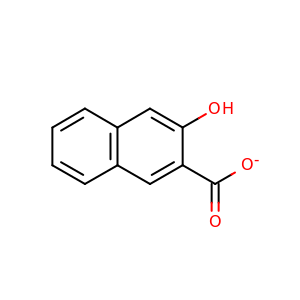

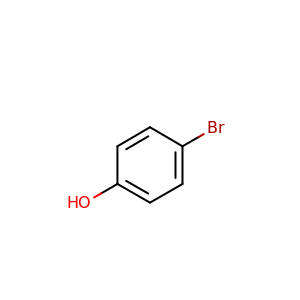

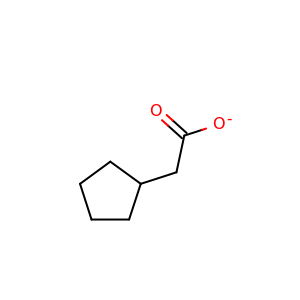

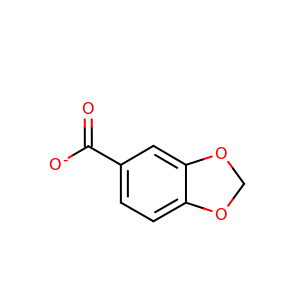

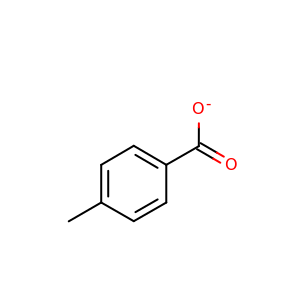

In [7]:
from openeye.oechem import *
from openeye.oeomega import * # conformer generation
from openeye.oequacpac import *
from openeye import oequacpac
from openeye import oedepict
from IPython.display import display, Image

mols_by_ID = {}
for idx in range(len(smiles)):
    # Generate new OEMol and parse SMILES
    mol = OEMol()
    OEParseSmiles( mol, smiles[idx])
    # Set netural pH model to pick a "reasonable" netural protonation per OpenEye's QuacPac
    OESetNeutralpHModel(mol)
    mols_by_ID[MoleculeIDs[idx]] = mol
    
    # check 2D versions of molecule
    oedepict.OEPrepareDepiction(mol)
    # set some display options
    image = oedepict.OEImage(300, 300)
    opts = oedepict.OE2DMolDisplayOptions(image.GetWidth(), image.GetHeight(), oedepict.OEScale_Default)
    
    # render and display
    disp = oedepict.OE2DMolDisplay(mol, opts)
    oedepict.OERenderMolecule(image, disp)
#     oedepict.OERenderMolecule("title.png", disp) # to save a file
    display(Image(oedepict.OEWriteImageToString("png",image)))

## Experimental Conditions
GDCC system experimental conditions:
10 mM sodium phosphate buffer at 25 C, pH 11.5

## pKa values:
G1 (3-hydroxy-2-naphthoic acid)
- hydroxyl 12.83 (4.48%), carboxyl 2.69 (95.52%)

G2 (4-Bromophenol)
- 9.17

G3 (cyclopentylacetic acid)
- 4.86

G4 (piperonylic acid)
- 4.10

G5 (p-toluic acid)
- 4.26

## Tweak protonation states for some compounds
### For GDCCs only G2 is affected. Hydroxyl is coming out protonated (neutral), should have -1 charge.  

In [8]:
for mol_id in ['G2']:
    mol = mols_by_ID[mol_id]
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum()==8:
            atom.SetFormalCharge(-1)
    mols_by_ID[mol_id]=mol

# Generate conformers and assign partial charges

In [10]:


for mol_id in mols_by_ID:
    #initialize omega, this is a conformation generator
    omega = OEOmega()
    #set the maximum conformer generated to 1
    omega.SetMaxConfs(1)
    omega.SetIncludeInput(False)
    omega.SetStrictAtomTypes(False) #Leniency in assigning atom types
    omega.SetStrictStereo(True) #Don't generate conformers if stereochemistry not provided. Setting to false would pick a random stereoisomer
    
    
    mol = mols_by_ID[mol_id]
    # Generate one conformer
    status = omega(mol)
    if not status:
        print("Error generating conformers for %s" % (mol_id))
        
    # Assign charges
    OEAssignPartialCharges(mol, OECharges_AM1BCC)
    
    # Write out PDB of molecule
    ofile = oemolostream('/home/amezcum1/SAMPL8/host_guest/GDCC/guest_files/%s.pdb'%(mol_id))
    OEWriteMolecule(ofile, mol)
    ofile.close()
    
    # Write out MOL2 of molecule
    ofile = oemolostream('/home/amezcum1/SAMPL8/host_guest/GDCC/guest_files/%s.mol2'%(mol_id))
    OEWriteMolecule(ofile, mol)
    ofile.close()
    
    # Write out SDF molecule
    ofile = oemolostream('/home/amezcum1/SAMPL8/host_guest/GDCC/guest_files/%s.sdf'%(mol_id))
    OEWriteMolecule(ofile, mol)
    ofile.close()

Error generating conformers for G2


## Make host files

In [12]:
hosts = ['TEMOA']
for idx in range( len( hosts ) ):
    inputfile = oemolistream('/home/amezcum1/SAMPL8/host_guest/GDCC/source_files/Hosts/TEMOA/%s.sdf'%(hosts[idx]) )
    mol = OEMol()
    OEReadMolecule( inputfile, mol )
    inputfile.close()

    # Write to a SDF file
    ofile = oemolostream( '/home/amezcum1/SAMPL8/host_guest/GDCC/host_files/%s.sdf'%(hosts[idx]) ) 
    OEWriteMolecule( ofile, mol)
    ofile.close()

    # Write to a mol2 file
    ofile = oemolostream(  '/home/amezcum1/SAMPL8/host_guest/GDCC/host_files/%s.mol2'%(hosts[idx]) )  
    OEWriteMolecule( ofile, mol)
    ofile.close()
    
    # Write to a PDB file
    ofile = oemolostream('/home/amezcum1/SAMPL8/host_guest/GDCC/host_files/%s.pdb'%(hosts[idx]) )
    OEWriteMolecule( ofile, mol)
    ofile.close()
    print("Host done:", hosts[idx])

Host done: TEMOA


In [13]:
hosts = ['TEEtOA']
for idx in range( len( hosts ) ):
    inputfile = oemolistream('/home/amezcum1/SAMPL8/host_guest/GDCC/source_files/Hosts/TEEtOA/%s.sdf'%(hosts[idx]) )
    mol = OEMol()
    OEReadMolecule( inputfile, mol )
    inputfile.close()

    # Write to a SDF file
    ofile = oemolostream( '/home/amezcum1/SAMPL8/host_guest/GDCC/host_files/%s.sdf'%(hosts[idx]) ) 
    OEWriteMolecule( ofile, mol)
    ofile.close()

    # Write to a mol2 file
    ofile = oemolostream(  '/home/amezcum1/SAMPL8/host_guest/GDCC/host_files/%s.mol2'%(hosts[idx]) )  
    OEWriteMolecule( ofile, mol)
    ofile.close()
    
    # Write to a PDB file
    ofile = oemolostream('/home/amezcum1/SAMPL8/host_guest/GDCC/host_files/%s.pdb'%(hosts[idx]) )
    OEWriteMolecule( ofile, mol)
    ofile.close()
    print("Host done:", hosts[idx])

Host done: TEEtOA
